In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import math
from sklearn.preprocessing import StandardScaler

from evolutionary_algorithm import EA

# Peptides

In [2]:
peptides_data_dir = "./data/peptides/"

ebola_data = pd.read_csv(peptides_data_dir + "ebola-6mers.txt", header=None)

ebola_data

,0
0,LEAMVN
1,DNFLYY
2,DEVLWE
3,YEAVYK
4,YDRLAS
...,...
135,GLISDW
136,LPIDFI
137,FWYDLA
138,LTLIKT


In [3]:
peptides = ebola_data[0].tolist()
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)
    
def compute_Fpep(peptide, position_freqs):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))

fpep_scores = [compute_Fpep(p, position_freqs) for p in peptides]

fpep_scores

[0.39999999999999997,
 0.5642857142857143,
 0.5357142857142857,
 0.40714285714285714,
 0.6071428571428571,
 0.5428571428571428,
 0.6071428571428571,
 0.41428571428571426,
 0.42857142857142855,
 0.4142857142857143,
 0.6285714285714286,
 0.6428571428571428,
 0.6428571428571428,
 0.4642857142857143,
 0.4928571428571428,
 0.5071428571428571,
 0.3214285714285714,
 0.4,
 0.6571428571428571,
 0.3214285714285714,
 0.4357142857142857,
 0.4928571428571429,
 0.5571428571428572,
 0.4928571428571428,
 0.5,
 0.45714285714285713,
 0.5714285714285714,
 0.35,
 0.33571428571428574,
 0.42857142857142855,
 0.6071428571428571,
 0.4642857142857143,
 0.5142857142857142,
 0.6,
 0.40714285714285714,
 0.40714285714285714,
 0.2714285714285714,
 0.35714285714285715,
 0.5,
 0.5642857142857143,
 0.3142857142857143,
 0.37857142857142856,
 0.2571428571428571,
 0.39999999999999997,
 0.32857142857142857,
 0.4714285714285714,
 0.5357142857142857,
 0.5857142857142857,
 0.4357142857142857,
 0.5499999999999999,
 0.36428571

In [4]:
def fitness(fpep_scores_set):
    if len(fpep_scores_set) == 0:
        return np.inf
    
    # Minimize avg fpep
    avg_fpep = np.mean(fpep_scores_set)
    
    # Maximize different kinds of fpep
    different_fpep = np.var(fpep_scores_set)
    
    # 1 & 0    is the same as what we had before
    weight_avg = 1
    weight_different = -3.0

    return (weight_avg * avg_fpep) + (weight_different * different_fpep)
    
    

In [5]:
ea = EA(
    data=fpep_scores,
    N=100,
    sigma=30,
    K=2,
    p=0.1,
    mu=0.01,
    T=1000,
    f=np.mean,
    seed=42
)
best_individual, best_fitness, fitness_avg, fitness_best = ea.run()

m_ea = EA(
    data=fpep_scores,
    N=100,
    sigma=30,
    K=2,
    p=0.1,
    mu=0.01,
    T=1000,
    f=fitness,
    seed=42
)
multi_best_individual, multi_best_fitness, multi_fitness_avg, multi_fitness_best = m_ea.run()

Gen 1: Best = 0.4173809523809524, Avg = 0.45159285714285713
Gen 2: Best = 0.41238095238095235, Avg = 0.44056666666666666
Gen 3: Best = 0.40833333333333327, Avg = 0.4346571428571429
Gen 4: Best = 0.40666666666666657, Avg = 0.43073333333333336
Gen 5: Best = 0.4023809523809524, Avg = 0.42718333333333325
Gen 6: Best = 0.39857142857142847, Avg = 0.4225952380952381
Gen 7: Best = 0.39833333333333326, Avg = 0.4192333333333334
Gen 8: Best = 0.4007142857142857, Avg = 0.416645238095238
Gen 9: Best = 0.39595238095238094, Avg = 0.4141785714285713
Gen 10: Best = 0.3971428571428571, Avg = 0.41122142857142857
Gen 11: Best = 0.392142857142857, Avg = 0.40886190476190476
Gen 12: Best = 0.38928571428571423, Avg = 0.40722857142857144
Gen 13: Best = 0.3861904761904762, Avg = 0.4042452380952382
Gen 14: Best = 0.38285714285714284, Avg = 0.4030285714285714
Gen 15: Best = 0.3845238095238095, Avg = 0.40162619047619047
Gen 16: Best = 0.3840476190476191, Avg = 0.3996714285714285
Gen 17: Best = 0.38119047619047625,

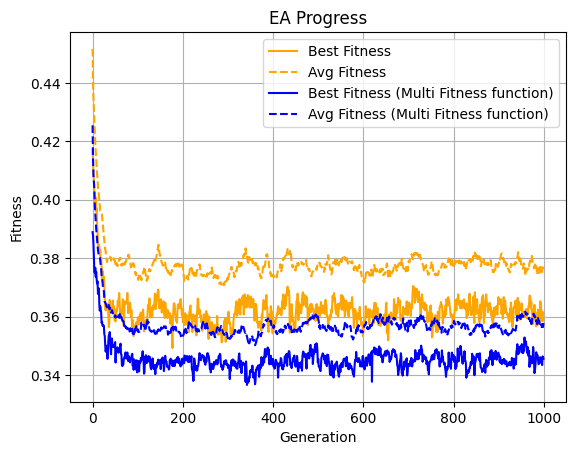

In [6]:
plt.plot(fitness_best, label='Best Fitness', linestyle='-', color='orange')
plt.plot(fitness_avg, label='Avg Fitness', linestyle='--', color='orange')
plt.plot(multi_fitness_best, label='Best Fitness (Multi Fitness function)', linestyle='-', color='blue')
plt.plot(multi_fitness_avg, label='Avg Fitness (Multi Fitness function)', linestyle='--', color='blue')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("EA Progress")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
optimal_peptides = [peptides[i] for i in best_individual]
optimal_peptides

['NVINYA',
 'IKPFLE',
 'FHTFFS',
 'FCICKF',
 'DAAPPV',
 'PLNTQG',
 'VLPFFT',
 'GSDGYK',
 'MFFWYD',
 'TYPKIG',
 'TTQIHN',
 'MTGRIP',
 'KPDETF',
 'ALAVPQ',
 'LIQKYQ',
 'NEENRF',
 'FNWMHY',
 'QAFEAG',
 'MKDEPV',
 'PKHIYR',
 'SDTEGM',
 'AFVSYY',
 'FFWYDL',
 'MHNQDG',
 'LEAMVN',
 'MLCLHH',
 'DWYQAS',
 'EQENFS',
 'HQGMHM',
 'DHCDNI']

In [8]:
multi_optimal_peptides = [peptides[i] for i in multi_best_individual]
multi_optimal_peptides

['SDTEGM',
 'TTQIHN',
 'LASLAT',
 'FFWYDL',
 'HQGMHM',
 'WKVNPE',
 'KAVVLK',
 'SDSACG',
 'QAIMTS',
 'SHLTQY',
 'MHNQDG',
 'MRTNFL',
 'LDQCDL',
 'FLESGA',
 'QDSEVK',
 'MKDEPV',
 'GSDGYK',
 'LIQKYQ',
 'MTGRIP',
 'KPDETF',
 'PKHIYR',
 'YHRYNL',
 'DHCDNI',
 'TYPKIG',
 'FNWMHY',
 'WTSISC',
 'FQRTFS',
 'LWEFYH',
 'YSFGAF',
 'VLPFFT']

Gen 1: Best = -0.5373808412346343, Avg = -0.006100002328366569
Gen 2: Best = -0.6028285412293671, Avg = -0.16685215172766593
Gen 3: Best = -0.6098902030684896, Avg = -0.2530120997684182
Gen 4: Best = -0.6441239950425324, Avg = -0.3145410978256664
Gen 5: Best = -0.7145322204141478, Avg = -0.37591265563198617
Gen 6: Best = -0.7516780245919861, Avg = -0.44728798656424973
Gen 7: Best = -0.7796855044931621, Avg = -0.49336721359529884
Gen 8: Best = -0.8052385083162228, Avg = -0.5210998684998427
Gen 9: Best = -0.8481801876371995, Avg = -0.5271287688220361
Gen 10: Best = -0.8895829881656716, Avg = -0.5570569271962013
Gen 11: Best = -0.9405290258073333, Avg = -0.5917881036405092
Gen 12: Best = -0.8749192556711396, Avg = -0.6245093665020086
Gen 13: Best = -0.8857538035735142, Avg = -0.6615544751525902
Gen 14: Best = -0.977486185682009, Avg = -0.7035892232245403
Gen 15: Best = -0.964493677754239, Avg = -0.7052644654176126
Gen 16: Best = -1.0756585232254838, Avg = -0.7419623982700719
Gen 17: Best 

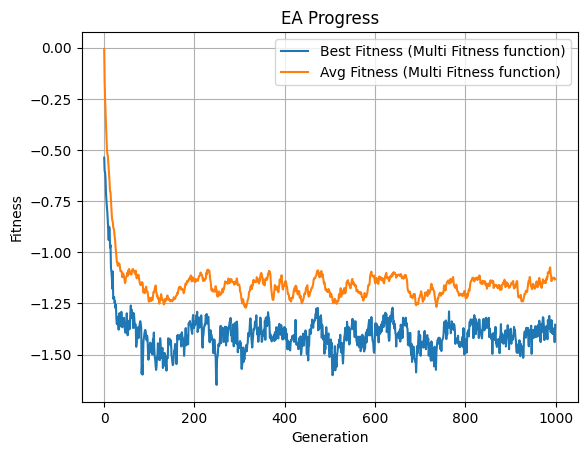

['PLNTQG',
 'FFWYDL',
 'AFVSYY',
 'DFKIVP',
 'QDSEVK',
 'LIQKYQ',
 'KAVVLK',
 'EQENFS',
 'FNWMHY',
 'MKDEPV',
 'MHNQDG',
 'IFETYC',
 'MFFWYD',
 'WLNDNL',
 'DWYQAS',
 'SDTEGM',
 'FHTFFS',
 'YEAVYK',
 'HQGMHM',
 'WTSISC',
 'VLSVFP',
 'DAAPPV',
 'TYPKIG',
 'FCICKF',
 'WKVNPE',
 'YHRYNL',
 'NEENRF',
 'MRTNFL',
 'PKHIYR',
 'MTGRIP']

In [23]:
peptides = ebola_data[0].tolist()
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)
    
def compute_Fpep(peptide):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))

def compute_aa_frequency_scores(peptides):
    aa_counts = defaultdict(int)
    total_aa = 0

    for p in peptides:
        for aa in p:
            aa_counts[aa] += 1
            total_aa += 1

    aa_freqs = {aa: count / total_aa for aa, count in aa_counts.items()}

    def score(peptide):
        return sum(aa_freqs[aa] for aa in peptide)

    return [score(p) for p in peptides]

aa_freq_scores = compute_aa_frequency_scores(peptides)

feature_vectors = []
for i, peptide in enumerate(peptides):
    fpep = compute_Fpep(peptide)
    aa = aa_freq_scores[i]
    feature_vectors.append([fpep, aa])
    
scaler = StandardScaler()
feature_vectors = scaler.fit_transform(feature_vectors)

def composite_fitness(subset: np.ndarray):
    fpep_mean = np.mean(subset[:, 0])
    aa_mean = np.mean(subset[:, 1])

    return (
        1 * fpep_mean
        + 0.5 * aa_mean
    )
    
m_ea = EA(
    data=feature_vectors,
    N=100,
    sigma=30,
    K=2,
    p=0.1,
    mu=0.02,
    T=1000,
    f=composite_fitness,
    seed=42
)
multi_best_individual, multi_best_fitness, multi_fitness_avg, multi_fitness_best = m_ea.run()

plt.plot(multi_fitness_best, label='Best Fitness (Multi Fitness function)')
plt.plot(multi_fitness_avg, label='Avg Fitness (Multi Fitness function)')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("EA Progress")
plt.legend()
plt.grid(True)
plt.show()

multi_optimal_peptides = [peptides[i] for i in multi_best_individual]
multi_optimal_peptides
